## Segmentation and Binary Classification for Fitzpatrick I-IV & V-VI

Note that in this notebook we show a few samples that are wikimedia commons, but the same process should be applied to [fitzpatrick17k](https://github.com/mattgroh/fitzpatrick17k) dataset to replicate the results on the paper. More details of the dataset can be found in [0](https://arxiv.org/abs/2104.09957).

[0] Groh, Matthew, Caleb Harris, Luis Soenksen, Felix Lau, Rachel Han, Aerin Kim, Arash Koochek, and Omar Badri. "Evaluating deep neural networks trained on clinical images in dermatology with the fitzpatrick 17k dataset." In Proceedings of the IEEE/CVF Conference on Computer Vision and Pattern Recognition, pp. 1820-1828. 2021.

### 1. Extract binary masks

In this step a folder directory with images is needed, the function will return a binary mask for each sample.  For simplicity purposes we used a color and region based segmentation implemented in [skindetector.py](./utils/skindetector.py), other more advanced methods can be plugged in this step such as [SAM](https://huggingface.co/docs/transformers/main/model_doc/sam).

In [1]:
from utils.skindetector import get_masks_folder

folder_name = "./data/dummy_samples/"

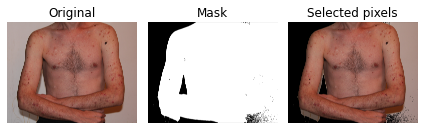

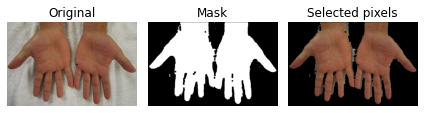

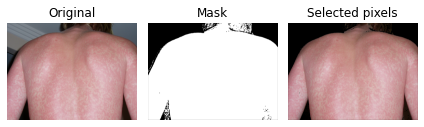

[array([[[  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0],
         ...,
         [  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0]],
 
        [[  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0],
         ...,
         [130, 137, 164],
         [129, 136, 163],
         [  0,   0,   0]],
 
        [[  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0],
         ...,
         [131, 138, 165],
         [131, 138, 165],
         [  0,   0,   0]],
 
        ...,
 
        [[  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0],
         ...,
         [116, 126, 144],
         [117, 127, 145],
         [  0,   0,   0]],
 
        [[  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0],
         ...,
         [117, 126, 146],
         [117, 126, 146],
         [  0,   0,   0]],
 
        [[  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0],
         ...,
         [  0,   0,   0],
  

In [2]:
masks = get_masks_folder(folder_name, output_path="./data/dummy_out/", plot=True)
masks

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

In [4]:
from utils.preprocessing_utils import preprocesing_masks_for_classification

The preprocessing mask function returns the raw pixel in two different color spaces as well as engineered feature vectors with ITA values optional

In [5]:
cielab_pixels, rgb_pixels, features_l = preprocesing_masks_for_classification(
    masks, ita=True
)

We save the masked data ready for training our classification models (sklearn & pytorch models), in *folder 1* you can save *Fitzpatrick V-VI* tones masks and similarly *0* for *Fitzpatrick I-IV* tones

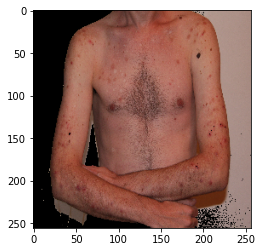

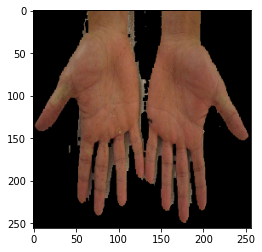

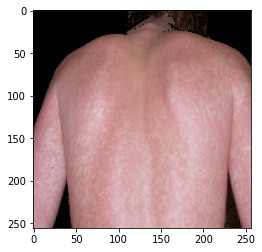

In [6]:
for i, p in enumerate(rgb_pixels):
    # print(p.shape)
    img = cv2.cvtColor(p.reshape(256, 256, 3), cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    # plt.imsave('data/all/1/{}.png'.format(i), img)
    plt.show()

### Train Binary Classifiers with pixel information and feature vectors

- $X$ will contain the feature that wants to be used (raw masked pixels, feature vectors HOG + ITA or HOG alone) a.k.a rgb_pixels, features_l ion previous line 
- $y$ will contain binary labels, 1 for *Fitzpatrick V-VI* and 0 for *Fitzpatrick I-IV* tones.

Note that for ITA estimation there are some values that return *nan* so we need to remove it before training the models from both $X$ & $y$. For that use something like `X[~np.isnan(X).any(axis=1), :]`

In our studies Extremely Randomized Trees and Balanced Random Forest Classifier show the best performance in traditional ML models.

In [ ]:
# https://scikit-learn.org/0.15/modules/cross_validation.html#cross-validation

import warnings
warnings.filterwarnings("ignore")
scores = ['f1', 'precision', 'accuracy', 'roc_auc', 'recall']

from sklearn.ensemble import RandomForestClassifier, \
                             ExtraTreesClassifier,\
                             AdaBoostClassifier,\
                             GradientBoostingClassifier
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.model_selection import cross_validate

models = [RandomForestClassifier(n_estimators=200), 
          BalancedRandomForestClassifier(n_estimators=200)
          ExtraTreesClassifier(n_estimators=200), 
          AdaBoostClassifier(n_estimators=100),
          GradientBoostingClassifier(n_estimators=100)
          ]

for m in models:
    for metric in scores:
        print('metric {}'.format(metric))
        cv_results = cross_validate(m, X, Y, cv=5, scoring=metric)
        #clf = clf.fit(X, Y)
        print('*'*20)
        print("CV for {} and metric {}".format(m.__class__, metric))
        print(cv_results['test_score'], np.array(cv_results['test_score']).mean(), 
              np.array(cv_results['test_score']).std())

In [ ]:
import sklearn
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

sklearn.metrics.SCORERS.keys()

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=0)

# Set the parameters by cross-validation
tuned_parameters = {"n_estimators": range(150, 200, 10)}
scores = ["f1", "precision", "accuracy", "roc_auc", "recall"]

for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
    # same done for BalancedRandomForestClassifier
    clf = GridSearchCV(ExtraTreesClassifier(), tuned_parameters, scoring=score)
    clf.fit(X_train, y_train)

    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    means = clf.cv_results_["mean_test_score"]
    stds = clf.cv_results_["std_test_score"]
    for mean, std, params in zip(means, stds, clf.cv_results_["params"]):
        print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))

    print("Detailed classification report:")
    print()
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print()
    y_true, y_pred = y_test, clf.predict(X_test)
    print(classification_report(y_true, y_pred))
    print(confusion_matrix(y_true, y_pred))

### Train Binary Classifier over pixel information with pre-trained ResNet
- First, we need to define preprocessing transformations (for training and test) and data splits, along with sampler definitions

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset, WeightedRandomSampler, Subset
from collections import Counter
from sklearn.utils.class_weight import compute_class_weight
from resnet_utils import BalancedBatchSampler

data_transforms = {
    "train": transforms.Compose(
        [
            transforms.Resize(256),
            transforms.RandomResizedCrop(224),
            transforms.RandomHorizontalFlip(),
            transforms.RandomVerticalFlip(),
            transforms.ToTensor(),
            transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5]),
        ]
    ),
    "test": transforms.Compose(
        [
            transforms.Resize(256),
            transforms.ToTensor(),
            transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5]),
        ]
    ),
}

data_dir_train = "data/train/"
data_dir_test = "data/test/"
# the structure of these folders will be
# data/train/0/ data/train/1/
# data/test/0/ data/test/1/

tones_data_train = datasets.ImageFolder(data_dir, transform=data_transforms["train"])
tones_data_test = datasets.ImageFolder(data_dir, transform=data_transforms["test"])

train_set, val_set = torch.utils.data.random_split(
    tones_data_train,
    [int(len(tones_data.samples) * 0.8), int(len(tones_data.samples) * 0.2)],
)
train_loader = torch.utils.data.DataLoader(
    train_set, sampler=BalancedBatchSampler(train_set), batch_size=32, shuffle=False
)

val_loader = torch.utils.data.DataLoader(val_set, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(tones_data_test, batch_size=32, shuffle=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

- Second, we load pretrained weights of ResNet18, loss function to use (note that we experimented with weighted loss) and a decay of the LR.

In case you want to use the class weight can be estimated as:

In [ ]:
from collections import Counter
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight(
    "balanced", np.unique(tones_data.targets), tones_data.targets
)
class_weights = torch.tensor(class_weights, dtype=torch.float)

print(dict(Counter(tones_data.targets)))
print(class_weights)

In [ ]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 2)
model_ft = model_ft.to(device)

# this option in case class weight was selected
# criterion = nn.CrossEntropyLoss(weight=class_weights.to(device), reduction='mean')
criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=10, gamma=0.1)

- Third, you wil train and save the model, see [resnet_utils.py](./utils/resnet_utils.py) for more details on the training process 

In [ ]:
model_ft = train_model(
    model_ft,
    criterion,
    optimizer_ft,
    exp_lr_scheduler,
    dataloaders,
    dataset_sizes,
    num_epochs=100,
)

In [ ]:
torch.save(model_ft.state_dict(), "trained_model.pth")

In [ ]:
# define the model architecture
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 2)

## load pretrained model to available device
tar = torch.load("trained_model.pth", map_location=device)
model_ft.load_state_dict(tar)
model_ft.cuda()

model_ft.eval()

In [ ]:
from utils_skin import iterations_test
from sklearn import metrics

y_real, y_pred = iterations_test(model_ft, test_loader)
print(metrics.classification_report(np.array(y_pred), np.array(y_real)))